# Introduction to Generative ML with Pyro

In [1]:
import matplotlib.pyplot as plt
import torch
import pyro
import numpy as np

pyro.set_rng_seed(101)

Our goal is to understand causal modeling within the context of generative machine learning. We just examined one generative machine learning framework called Bayesian networks (BNs) and how we can use BNs as causal models.

**Bayesian Networks (BNs)** Framework that defines a probabilistic generative model of the world in terms of a directed acyclic graph.

**causal Bayesian networks:** Bayesian networks where the direction of edges in the DAG represent causality.

Bayesian networks provide a general-purpose framework for representing a causal data generating story for how the world works.

Now we will introduce probabilistic programming, a framework that is more expressive than Bayesian networks.

### What is a probabilistic programming language?

"A probabilistic programming language (PPL) is a programming language designed to describe probabilistic models and then perform inference in those models. PPLs are closely related to graphical models and Bayesian networks but are more expressive and flexible. Probabilistic programming represents an attempt to "Unify general purpose programming" with probabilistic modeling."

-Wikipedia

A PPL is a domain-specific programming language for that lets you write a data generating story as a program. As with a causal Bayesian network, you can write your program in a way that orders the steps of its execution according to cause and effect.

### How exactly do Bayesian networks and probabilistic programming differ?

**Representation of relationships between variables**.  BNs restricted to representing the relationships between variables in terms of conditional probability distributions (CPDs) factored according to a DAG.  Frameworks typically limit you to a small set of parametric CPDs (e.g., Gaussian, multinomial).

Just as computer programs are more expressive than flow charts, PPLs let you represent relations any way you like so long as you can represent them in code.  PPL relationships can include control flow and recursion.  In causal models, we will see that this allows you to be more specific about mechanism than you can with CPDs.

**DAG vs. open world models**.  BNs restrict the representation of the joint distribution to a DAG.  This constraint enables you to reason easily about the joint distribution through graph-theoretic operations like d-separation.  PPLs need not be constrained to a DAG.  For example (using an imaginary Python PPL package):

    X = Bernoulli(p)
    if X == 1:
        Y = Gaussian(0, 1)

In a DAG, you have a fixed set of variables, i.e. a "closed world".  In the above model, the variable Y is only instantiated if X==1.  Y may or may not exist depending on how the generative process unfolds.  For a more extreme example, consider this:

    X = Poisson(λ)
    Y = [Gaussian(0, 1)]
    for i in range(1, X):
        Y[i] = Gaussian(Y[i-1], 1))

Here you have the total number of Y variables itself being a random variable X.  Further, the mean of the ith Y is a random variable given by the i-1th Y.  You can't do that with a Bayes net!  Unfortunately, we can't reason about this as directly as we can with a DAG.  For example, recall that with the DAG, we had a convenient algorithm called `CPDAG` that converts the DAG to a partially directed acyclic graph structure called a PDAG that provides a compact representation of all the DAGs in an equivalence class.  How might we define an equivalence class on this program?  Certainly, enumerating all programs with an equivalent representation of the joint distribution would be very difficult even with constraints on the length of the program.  In general, enumerating all programs of minimal description that provide equivalent representations of a joint distribution is an NP-hard problem.

**Inference**  When you have a DAG and a constrained set of parametric CPDs, as well as constraints on the kind of inference,  queries the user can make, you can implement some inference algorithms in your BN framework that will generally work in a reasonable amount of time.

PPLs are more flexible than BNs, but the trade-off s that getting inference to work is harder.   PPL's develop several abstractions for inference and leave it to the user to apply them, requiring the user to become something of an expert in inference algorithms.  PPL developers make design decisions to make inference easier for the user, though this often sacrifices some flexibility.  One emergent pattern is to build PPLs on tensor-based frameworks like Tensorflow and PyTorch.  Tensor-based PPLs allow a data scientist with experience building deep learning models to rely on that experience when doing inference.

![Image](../fig/inference.png)

[$$\texttt{Kevin Smith - Tutorial: Probabilistic Programming}$$](https://www.youtube.com/watch?v=9SEIYh5BCjc)

## Introduction to Pyro

Pyro is a universal probabilistic programming language (PPL) written in Python and supported by PyTorch on the backend. Pyro enables flexible and expressive deep probabilistic modeling, unifying the best of modern deep learning and Bayesian modeling.

Our purpose of this class, pyro has "do"-operator that allows intervention and counterfactual inference in these probabilistic models.

### Stochastic Functions

The basic unit of probabilistic programs is the stochastic function. A stochastic function is an arbitrary Python callable that combines two ingredients:

- deterministic Python code; and
- primitive stochastic functions that call a random number generator

For this course, we will consider these stochastic functions as **models**. Stochastic functions can be used to represent simplified or abstract descriptions of a data-generating process.

### Primitive stochastic functions

We call them distributions. We can explicitly compute the probability of the outputs given the inputs.

In [2]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
x = normal.rsample() # draw a sample from N(0,1)
print("sample: ", x)

sample:  tensor(-1.3905)


Pyro simplifies this process of sampling from distributions. It uses `pyro.sample()`.

In [3]:
x = pyro.sample("my_sample", pyro.distributions.Normal(loc, scale))
print(x)

tensor(-0.8152)


Just like a direct call to `torch.distributions.Normal().rsample()`, this returns a sample from the unit normal distribution. The crucial difference is that this sample is named. Pyro’s backend uses these names to uniquely identify sample statements and change their behavior at runtime depending on how the enclosing stochastic function is being used. This is how Pyro can implement the various manipulations that underlie inference algorithms.

Let's write a simple `weather` model.

### A simple model

In [4]:
import pyro.distributions as dist

def weather():
    cloudy = pyro.sample('cloudy', dist.Bernoulli(0.3))
    cloudy = 'cloudy' if cloudy.item() == 1.0 else 'sunny'
    mean_temp = {'cloudy': 55.0, 'sunny': 75.0}[cloudy]
    scale_temp = {'cloudy': 10.0, 'sunny': 15.0}[cloudy]
    temp = pyro.sample('temp', dist.Normal(mean_temp, scale_temp))
    return cloudy, temp.item()

for _ in range(3):
    print(weather())

('cloudy', 64.5440444946289)
('sunny', 94.37557983398438)
('sunny', 72.5186767578125)


First two lines introduce a binary variable `cloudy`, which is given by a draw from the Bernoulli distribution with a parameter of $0.3$. The Bernoulli distribution returns either $0$ or $1$, line `2` converts that into a string. So, So according to this model, $30%$ of the time it’s cloudy and $70%$ of the time it’s sunny.

In line `4` and `5`, we initialize mean and scale of the temperature for both values. We then sample, the temperature from a Normal distribution and return that along with `cloudy` variable.


We can build complex model by modularizing and reusing the concepts into functions and use them as programmers use functions.

In [5]:
def ice_cream_sales():
    cloudy, temp = weather()
    expected_sales = 200. if cloudy == 'sunny' and temp > 80.0 else 50.
    ice_cream = pyro.sample('ice_cream', pyro.distributions.Normal(expected_sales, 10.0))
    return ice_cream

## Inference

As we discussed earlier, the reason we use PPLs is because they can easily go backwards and reason about cause given the observed effect. There are myriad of inference algorithms available in pyro. Let's try it on an even simpler model.

$$weight \mid guess \sim \mathcal{N}(guess, 1)$$

$$measurement \mid guess, weight \sim \mathcal{N}(weight, 0.75)$$


In [6]:
def scale(guess):
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    return measurement

scale(14.)

tensor(14.1712)

Suppose we observe that the `measurement` of an object was $14$ lbs. What would have we guessed if we tried to guess it's `weight` first?

This question is answered in two steps.

1. Condition the model.

In [7]:
conditioned_scale = pyro.condition(scale,{"measurement": torch.tensor(14.)})

2. Set the prior and infer the posterior. We will use the Hamiltonian Monte Carlo (HMC) inference algorithm with the no U-turn sampler (NUTS), like you would in a language like Stan.

Sample: 100%|██████████| 1300/1300 [00:02, 615.68it/s, step size=1.13e+00, acc. prob=0.921]


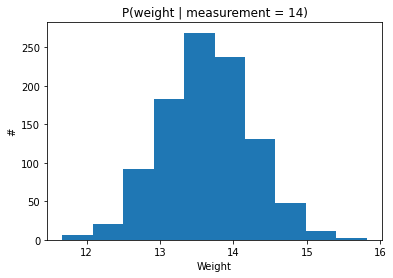

In [8]:
from pyro.infer import NUTS, MCMC, EmpiricalMarginal

guess_prior = torch.tensor(13.)

nuts_kernel = NUTS(conditioned_scale, adapt_step_size=True)
posterior = MCMC(nuts_kernel, 
                 num_samples=1000, 
                 warmup_steps=300)
posterior.run(guess_prior)
marginal = posterior.get_samples()['weight'] # get_samples returns a dictionary keyed by the site name 

plt.hist(marginal)
plt.title("P(weight | measurement = 14)")
plt.xlabel("Weight")
plt.ylabel("#")
print(posterior)



### Importance Sampling for inferring discrete quantities

Let us consider the following Bayesian network and the probabilities associated with each of the events as shown

![Image](https://i.stack.imgur.com/9NijE.gif)

Implementing the bayesian net in pyro :

#### Shapes in distribution:

We know that PyTorch tensors have single `shape` attribute, `Distribution`s have two shape attributes with special meaning. 
* `.batch_shape`: Indices over `.batch_shape` denote conditionally independent random variables,
* `.event_shape`: indices over `.event_shape` denote dependent random variables (ie one draw from a distribution).

These two combine to define the total shape of a sample. Thus the total shape of `.log_prob()` of distribution is `.batch_shape`.

Also, `Distribution.sample()` also has a `sample_shape` attribute that indexes over independent and identically distributed(iid) random variables.

```
      |      iid     | independent | dependent
------+--------------+-------------+------------
shape = sample_shape + batch_shape + event_shape
```

To learn more see [broadcasting tensors in PyTorch](https://pytorch.org/docs/master/notes/broadcasting.html).

### Examples

One way to introduce batch_shape is use `expand`.

```{python}
d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3, 3)).expand([5]) # expand - 3 of these Multivariate Normal Dists
print("batch_shape: ", d.batch_shape)
print("event_shape: ", d.event_shape)

#x = d.sample(torch.Size([5]))
x = d.sample()
print("x shape: ", x.shape)          # == sample_shape + batch_shape + event_shape
print("d.log_prob(x) shape:", d.log_prob(x).shape)  # == batch_shape
```

The other way is using `plate` context manager.

Pyro models can use the context manager `pyro.plate` to declare that certain batch dimensions are independent. Inference algorithms can then take advantage of this independence to e.g. construct lower variance gradient estimators or to enumerate in linear space rather than exponential space.



In [9]:
def model():
    burglar = pyro.sample("B", dist.Categorical(torch.tensor([0.999, 0.001]))) 
    earthquake = pyro.sample("E", dist.Categorical(torch.tensor([0.998, 0.002])))
    alarm_probs = torch.tensor([[[0.999, 0.001],[0.71,0.29]],[[0.06, 0.94],[0.05, 0.95]]])
    alarm = pyro.sample("A", dist.Categorical(alarm_probs[burglar][earthquake]))
    john_probs = torch.tensor([[0.95, 0.05], [0.1, 0.9]])
    mary_probs = torch.tensor([[0.99, 0.01], [0.3, 0.7]])
    john_calls = pyro.sample("J", dist.Categorical(john_probs[alarm]))
    mary_calls = pyro.sample("M", dist.Categorical(mary_probs[alarm]))


Let's say we know that the alarm went off (alarm = 1 ) and Mary called. Can we use the model to infer about the possibility of an earthquake ?

In [10]:
# condition on the model with observation/evidence
conditioned_model = pyro.condition(model, data = {'M': torch.tensor(1), 'A': torch.tensor(1)})

Perform posterior inference using Importance sampling


Text(0.5, 1.0, 'Earthquake|Alarm=On, Mary Called')

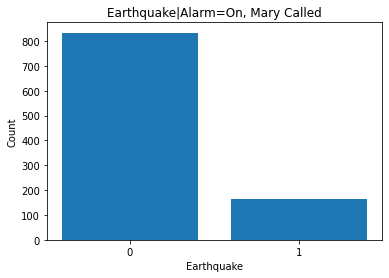

In [11]:

posterior = pyro.infer.Importance(conditioned_model, num_samples=1000).run()
# get the marginal distribution of the variable we are interested in (In our case its earthquake)
marginal = pyro.infer.EmpiricalMarginal(posterior, "E") 
earthquake_samples = np.array([marginal().item() for _ in range(1000)])
e_unique, e_counts = np.unique(earthquake_samples, return_counts=True)
plt.xlabel("Earthquake")
plt.ylabel("Count")
plt.bar(e_unique, e_counts) 
plt.xticks(e_unique)
plt.title('Earthquake|Alarm=On, Mary Called')

What is the probability that there was an earthquake , given alarm went off 
and Mary called?

In [12]:
print(earthquake_samples.mean())

0.166


### Gaussian Mixture Model

![Image](../fig/gmm.png)

[$$\texttt{Blei - Build, Compute, Critique, Repeat:Data Analysis with Latent Variable Models}$$](http://www.cs.columbia.edu/~blei/papers/Blei2014b.pdf)

Here is an example of how to implement a Gaussian mixture model in Pyro.

In [13]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

from matplotlib import pyplot
# %matplotlib inline

pyro.enable_validation(True)

data = torch.tensor([0., 1., 10., 11., 12.])

K = 2  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In fact, we can also nest `plates`. The only thing we need to care about is, which dimensions are independent. Pyro automatically manages this but sometimes we need to explicitely specify the dimensions. Once we specify that, we can leverage PyTorch's CUDA enabled capabilities to run inference on GPUs.

```
with pyro.plate("x_axis", 320):
    # within this context, batch dimension -1 is independent
    with pyro.plate("y_axis", 200):
        # within this context, batch dimensions -2 and -1 are independent
```

Note that we always count from the right by using negative indices like $-2$, $-1$.
```
with pyro.plate("x_axis", 5):
    d = dist.MultivariateNormal(torch.zeros(3), torch.eye(3, 3))
    x = pyro.sample("x", d)
x.shape
```

### Review of Approximate Inference

We have variables $Z$s (cluster assignments) and $X$s (data points) in our mixture model, where $X$ is observed and $Z$ is latent (unobserved). As we saw earlier, a generative model entails a joint distribution
$$p(Z,X)$$

Inference of unknown can be achieved through conditioning on the observations.

$$p(Z \mid X) = \frac{p(Z, X)}{p(X)}$$

For non-trivial interesting problems, the integral for the denominator(marginal) is not tractable.
$$p(X) = \int dZp(X \mid Z)p(Z)$$ 

So we have to directly approximate $p(Z \mid X)$. The most popular way of doing this is with *stochastic variational inference* because it can make use of the loss function optimization infrastructure in PyTorch.

### Variational Inference:

We can't compute $p(Z \mid X)$ directly, so let's approximate with some other distribution $q(Z; \nu)$ over Z that is tractable (for example, Gaussions or other exponential family).

![Image](../fig/VI.png)

[$$\texttt{David Blei - Variational Inference (NeurIPS 2016 Tutorial)}$$](https://www.youtube.com/watch?v=ogdv_6dbvVQ)

Since q is tractable, we can play with it's parameter $\nu$ such that it reaches as close to $p(Z\mid X)$ as possible. More precisely, we want to minimize the KL divergence between $q$ and $p$. With this trick, we just turned an **inference** problem to an **optimization** problem!

$$
\begin{align*}
KL(q(Z;\nu) \mid\mid p(Z\mid X)) &= -\int dZ\ q(Z) \log\frac{P(Z\mid X)}{q(Z)}\\
&= -\int dZ\ q(Z) \log 
\frac{\frac{p(Z,X)}{p(X)}}{q(Z)}\\
&= -\int dZ\ q(Z) \log 
\frac{p(Z,X)}{p(X)q(Z)}\\
&= -\int dZ\ q(Z) 
\left[
\log 
\frac{p(Z,X)}{q(Z)}
- \log p(X)
\right]\\
&= - \int dZ\ \log \frac{p(Z,X)}{q(Z)} + \underbrace{\int dZ\ q(Z)}_{\text{=1}}\log p(X)\\
&= - \int dZ\ \log \frac{p(Z,X)}{q(Z)} + \log p(X)\\
\log p(X) &= KL(q(Z;\nu)\mid\mid p(Z\mid X) + \underbrace{\int dZ\ q(Z;\nu) \log \frac{p(Z,X)}{q(Z;\nu)}}_{\mathcal{L}}\\
\end{align*}
$$

Note that we already observed $X$ and we conditioned the model to get $p(Z \mid X)$. But given $X$, $\log p(X)$ is constant! So, minimizing KL is equivalent to maximizing $\mathcal{L}$.

**How do you maximize $\mathcal{L}$**? Take $\nabla_{\nu} \mathcal{L}$.

$\mathcal{L}$ is called **variational lower bound**. It is often called ELBO.

**Stochastic Variational Inference** scales variational inference to massive data. Just like in stochastic variational inference, you subsample the data and update the posterior!

<!-- #region -->
### Stochastic Optimization

In stochastic optimization, we replace the gradient with cheaper noisy estimate which is guranteed to converge to a local optimum.

$$\nu_{t+1} = \nu_t + \rho_t \hat{\nabla}_{\nu} \mathcal{L}(\nu_t)$$

Requirements:

* Unbiased gradients, i.e.
$$\mathbb{E}[\hat{\nabla}_{\nu} \mathcal{L}(\nu_t)] = \nabla_{\nu}\mathcal{L}(\nu)$$

* Step-size sequence $\rho_t$ that follows Robbins-Monro conditions.


Stochastic variational inference takes inspiration from stochastic optimization and natural graidient. We follow the same procedure as stochastic gradient descent.
<!-- #endregion -->

### A Rough Stochastic variational inference algorithm:

* Initialize $q$ with some $\nu$
* Until Converge:
    * subsample from Data:
        * compute gradient $\hat{\nabla_{\nu}}\mathcal{L}_{\nu_t}$
        * update global parameter $\nu_{t+1} = \nu_t + \rho_t \hat{\nabla_{\nu}}\mathcal{L}_{\nu_t}$
* Return $q(Z;\nu)$

### Training a MAP estimator

Let's start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will use `AutoDelta` guide function. Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components.

During inference, `TraceEnum_ELBO` will marginalize out the assignments of datapoints to clusters.

`max_plate_nesting` lets Pyro know that we’re using the rightmost dimension plate and that Pyro can use any other dimension for parallelization.

## Some other Pyro vocabulary

* poutine - Beneath the built-in inference algorithms, Pyro has a library of composable effect handlers for creating new inference algorithms and working with probabilistic programs. Pyro’s inference algorithms are all built by applying these handlers to stochastic functions.
    * poutine.block - blocks pyro premitives. By default, it blocks everything.

* param - Parameters in Pyro are basically thin wrappers around PyTorch Tensors that carry unique names. As such Parameters are the primary stateful objects in Pyro. Users typically interact with parameters via the Pyro primitive `pyro.param`. Parameters play a central role in stochastic variational inference, where they are used to represent point estimates for the parameters in parameterized families of models and guides.

* param_store - Global store for parameters in Pyro. This is basically a key-value store.

In [14]:
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [15]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = 928.9263305664062


In [16]:
svi.loss(model, global_guide, data)

928.9263305664062

In [17]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))
losses = []
for i in range(200):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

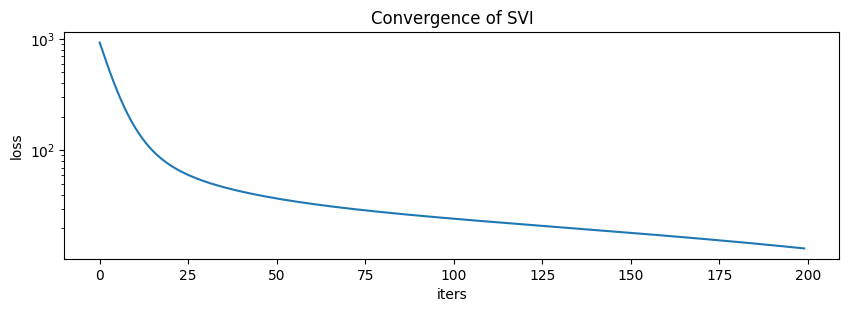

In [18]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

In [19]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [1.0212619e-13 1.0000000e+00]
locs = [1.12033995e-04 2.94428706e+00]
scale = 4.988683223724365


Text(0, 0.5, 'probability density')

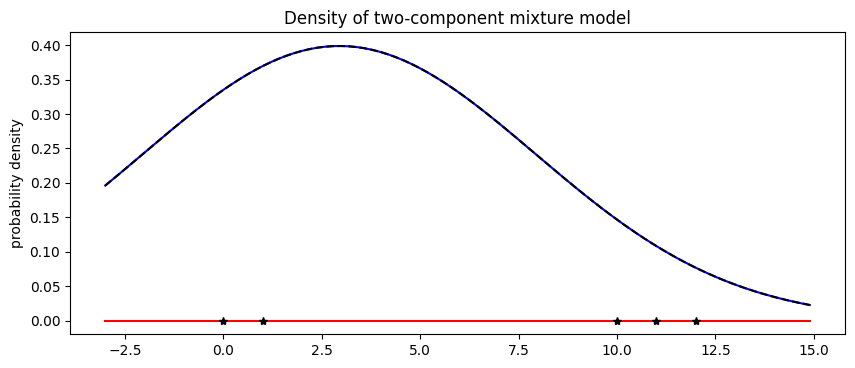

In [20]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

plt.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
plt.plot(X, Y1, 'r-')
plt.plot(X, Y2, 'b-')
plt.plot(X, Y1 + Y2, 'k--')
plt.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
plt.title('Density of two-component mixture model')
plt.ylabel('probability density')